In [11]:
library(tidyverse)
library(gridExtra)
library(ggExtra)
library(scales)
library(grid)


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



In [2]:
edges_df <- read_tsv('../../data/3.all_nodes/ppi.tsv.xz')
full_features <- read_tsv('../../data/4.data/ppi.tsv.xz')
features_df <- read_csv('prediction_features.csv.gz')

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double(),
  edge_prior = col_double(),
  rwr = col_double(),
  mean_rwr = col_double(),
  p_rwr = col_double(),
  jaccard = col_double(),
  mean_jaccard = col_double(),
  p_jaccard = col_double()
)
Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  adamic_adar_index = col_double(),
  preferential_attachment = col_double(),
  resource_allocation_index = col_double(),
  source = col_double(),
  target = col_double()
)


In [3]:
df <- features_df %>%
    left_join(edges_df, by = c("id_a", "id_b")) %>%
    left_join(full_features, by = c("id_a", "id_b", "name_a", "name_b", "train", "test_recon", "test_new"))

head(df, 2)

id_a,id_b,adamic_adar_index,preferential_attachment,resource_allocation_index,source,target,name_a,name_b,train,test_recon,test_new,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
0,1,0.0000000,165,0.0000,55,3,A0A087WT00,A0A0B4J1W7,0,0,0,0,1.582702e-05,1.455860e-05,0.088,0.000000000,0.001491855,1.000
0,2,0.2282049,3520,0.0125,55,64,A0A087WT00,A0AV96,0,0,0,0,7.970098e-05,6.923833e-05,0.250,0.008474576,0.014554941,0.819


In [4]:
vis_df <- df %>%
    sample_n(200000) %>%
    mutate(
        geo_mean_degree = (source * target) ^ 0.5,
        ari_mean_degree = (source + target) / 2
    ) %>%
    gather(key = 'feature', value = 'feature_value', adamic_adar_index:resource_allocation_index, rwr:p_jaccard) %>%
    gather(key = 'degree_side', value = 'degree', source, target, geo_mean_degree, ari_mean_degree) %>%
    mutate(
        degree_side = (
            degree_side %>% 
                recode_factor(source = 'source degree', target = 'target degree',
                              geo_mean_degree = 'geometric mean degree', 
                              ari_mean_degree = 'arithmetic mean degree',)
        ),
        test_edge = test_new %>% recode_factor(`0` = 'no unbiased edge', `1` = 'unbiased edge')
    ) %>%
    select(-starts_with('name')) %>%
    filter(!grepl('mean_|p_', feature) & feature != 'jaccard_coefficient') 

head(vis_df, 2)

id_a,id_b,train,test_recon,test_new,edge_prior,feature,feature_value,degree_side,degree,test_edge
1005,3498,0,0,0,0.013,adamic_adar_index,0.1835961,source degree,35,no unbiased edge
978,3602,0,0,0,0.021,adamic_adar_index,0.0000000,source degree,120,no unbiased edge


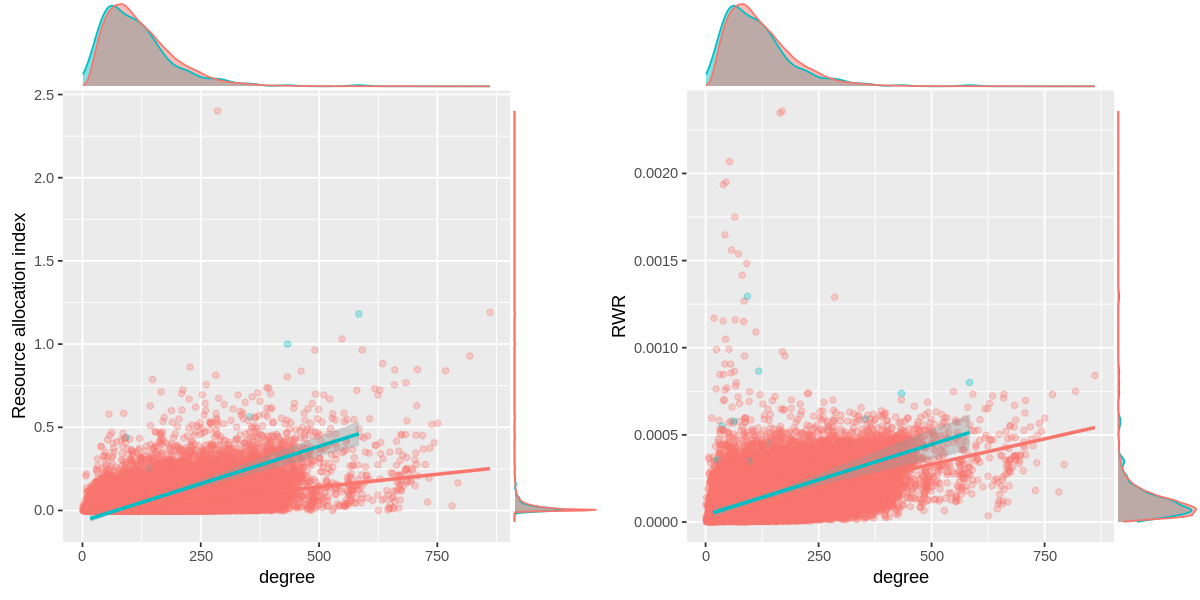

In [6]:
options(repr.plot.width=10, repr.plot.height=5)

scatter1 <- (
    ggplot(vis_df %>% filter(degree_side == 'arithmetic mean degree' & feature == 'resource_allocation_index'),
          aes(x = degree, y = feature_value, color = test_edge))
    + geom_point(alpha=0.3)
    + geom_smooth(method='lm')
    + theme(legend.position = "none")
    + ylab('Resource allocation index')
)
scatter1 <- ggMarginal(scatter1, groupColour = T, groupFill = T)

scatter2 <- (
    ggplot(vis_df %>% filter(degree_side == 'arithmetic mean degree' & feature == 'rwr'),
          aes(x = degree, y = feature_value, color = test_edge))
    + geom_point(alpha=0.3)
    + geom_smooth(method='lm')
    + theme(legend.position = "none")
    + ylab('RWR')
)
scatter2 <- ggMarginal(scatter2, groupColour = T, groupFill = T)


grid.arrange(scatter1, scatter2, ncol = 2)

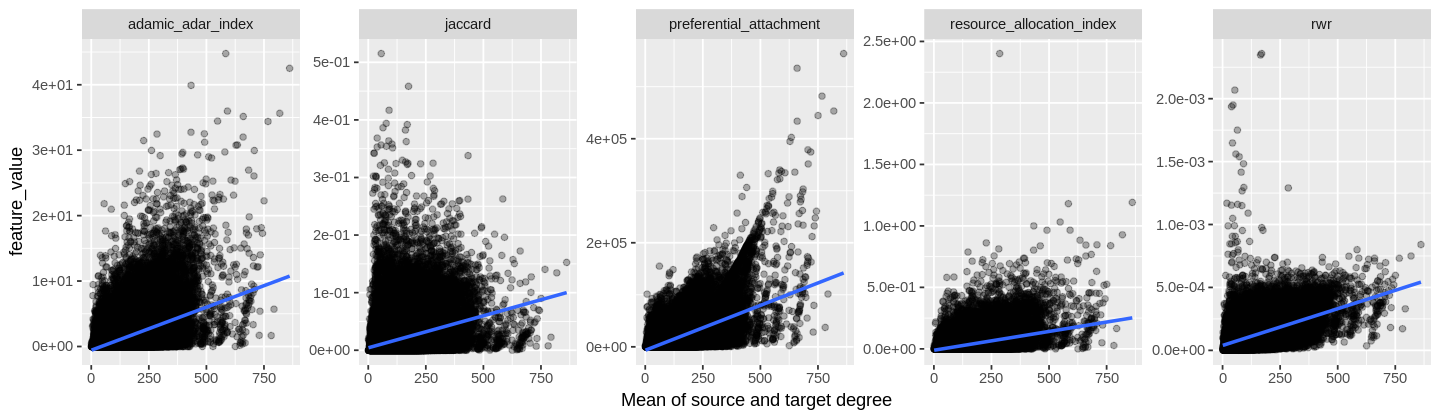

In [14]:
options(repr.plot.width=12, repr.plot.height=3.5)

# scatter_vertical <- (
#     ggplot(vis_df %>% filter(degree_side == 'arithmetic mean degree'), aes(x = degree, y = feature_value, 
#                                                                            color = test_edge))
#     + geom_point(alpha=0.3)
#     + geom_smooth(method='lm')
#     + facet_grid(rows = vars(feature), scales='free')
# )
# ggsave(plot = scatter_vertical, height = 10, width = 4,
#        filename = '../../img/link_prediction_features_degree_vertical.png')


scatter_horizontal <- (
    ggplot(vis_df %>% filter(degree_side == 'arithmetic mean degree'), aes(x = degree, y = feature_value))
    + geom_point(alpha=0.3)
    + geom_smooth(method='lm')
    + facet_wrap(vars(feature), scales='free', nrow = 1)
    + xlab('Mean of source and target degree')
    + scale_y_continuous(labels=scientific)
)
ggsave(plot = scatter_horizontal, height = 3, width = 12,
       filename = '../../img/link_prediction_features_degree_horizontal.png')
scatter_horizontal

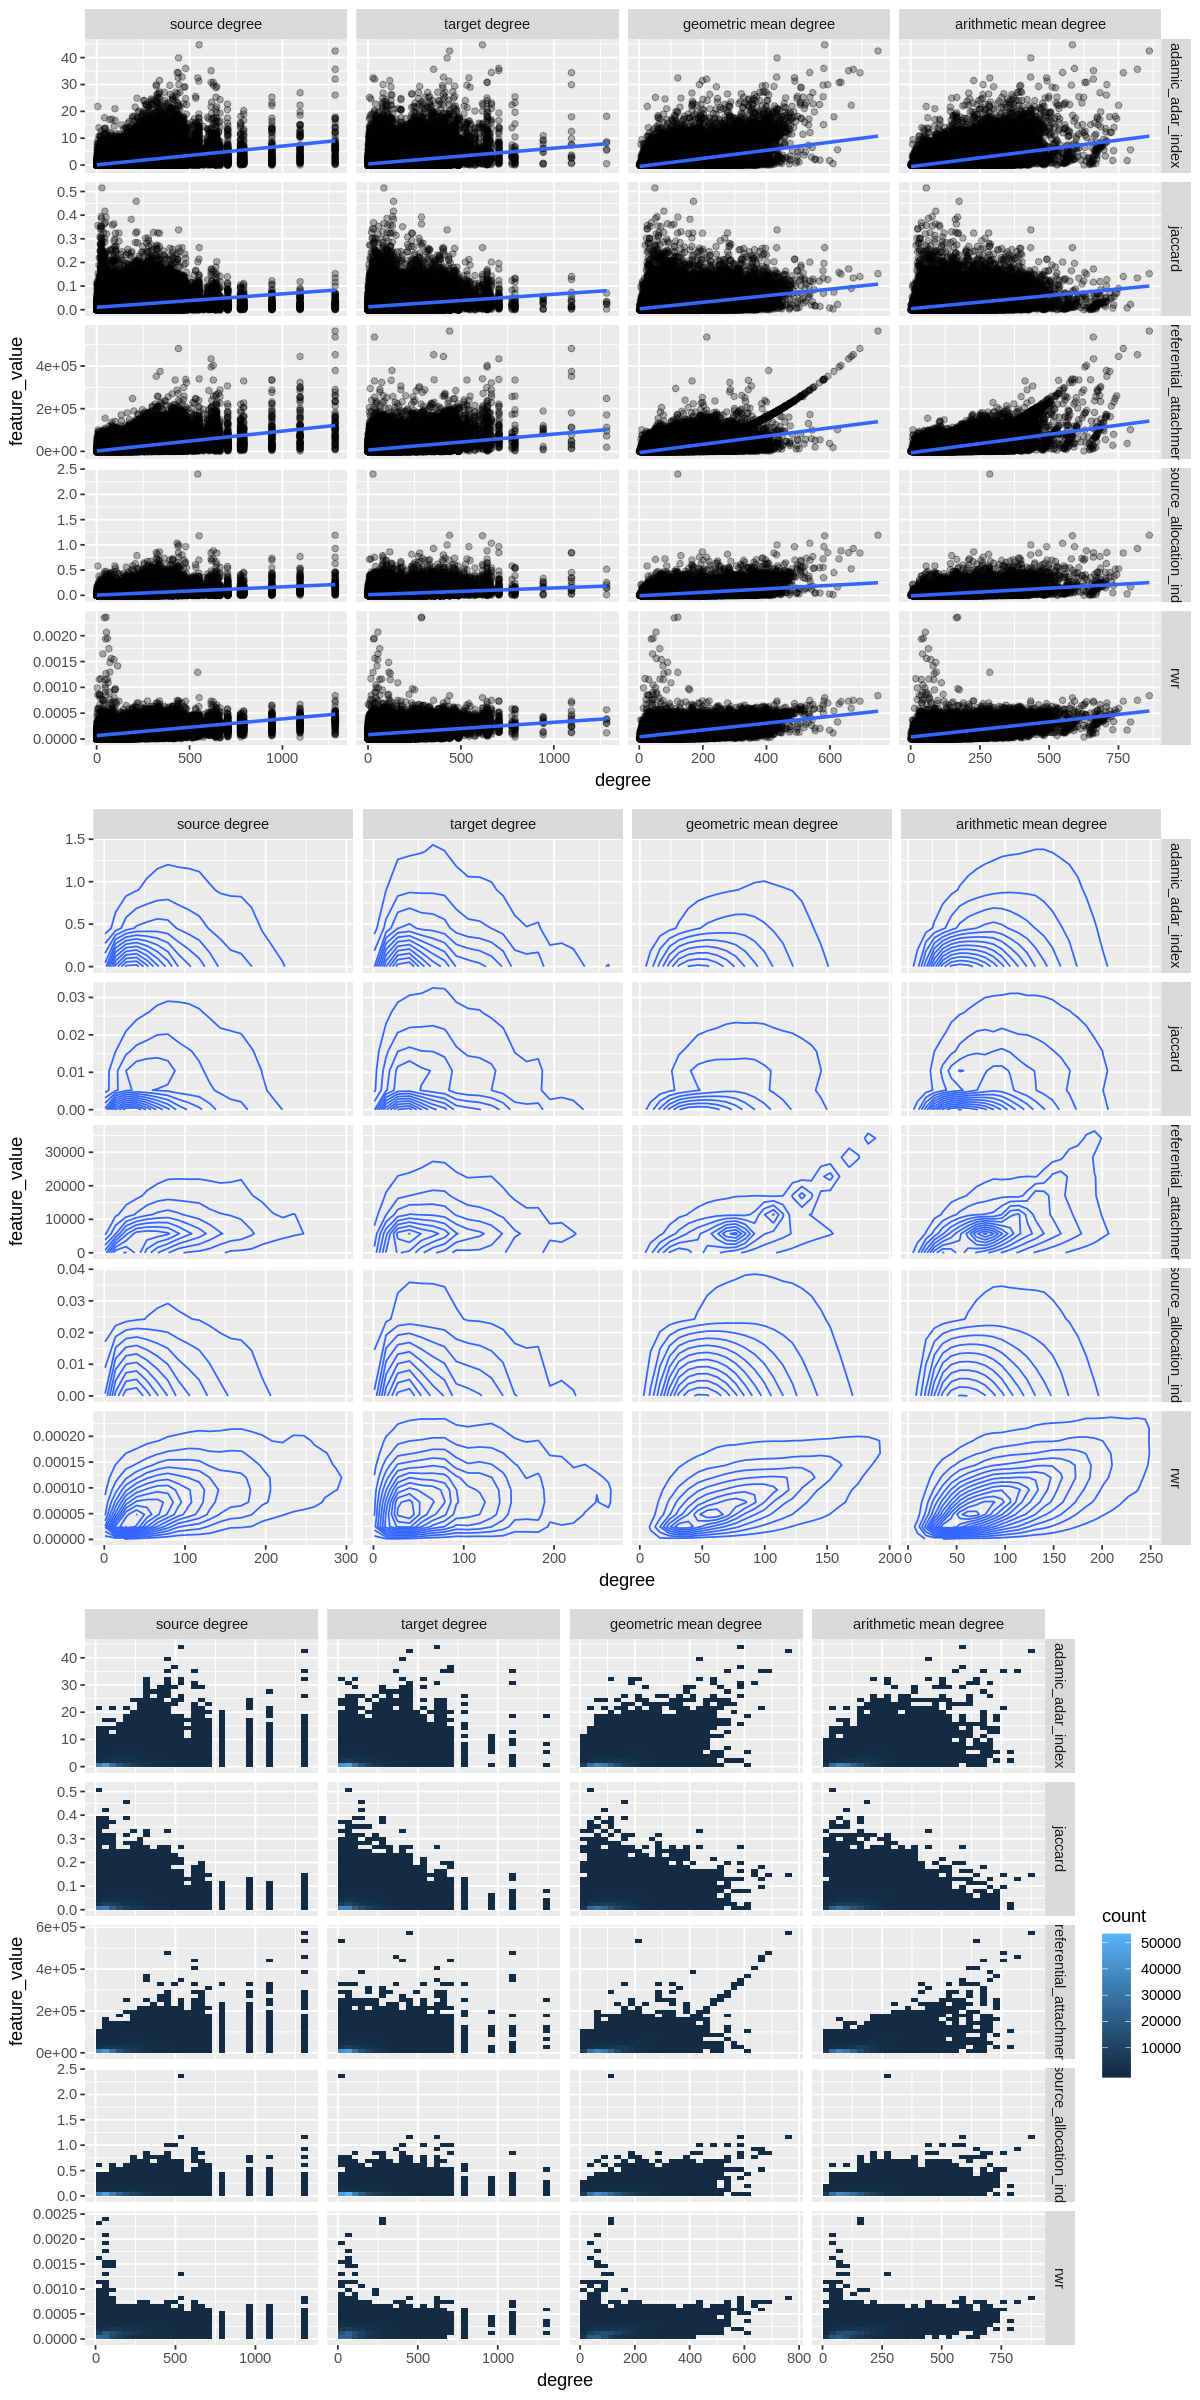

In [8]:
options(repr.plot.width=10, repr.plot.height=20)

scatter <- (
    ggplot(vis_df, aes(x = degree, y = feature_value))
    + geom_point(alpha=0.3)
    + geom_smooth(method='lm')
    + facet_grid(cols = vars(degree_side), rows = vars(feature), scales='free')
)

contour <- (
    ggplot(vis_df, aes(x = degree, y = feature_value))
    + geom_density_2d()
#     + geom_smooth(method='lm')
    + facet_grid(cols = vars(degree_side), rows = vars(feature), scales='free')
)

heatmap <- (
    ggplot(vis_df, aes(x = degree, y = feature_value))
    + geom_bin2d()
#     + geom_smooth(method='lm')
    + facet_grid(cols = vars(degree_side), rows = vars(feature), scales='free')
)

grid.arrange(scatter, contour, heatmap, ncol = 1)